In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
import wandb

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f'Torch version: {torch.__version__}, Device: {device.type}')

Torch version: 2.6.0, Device: mps


In [3]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: jaron-matzinger to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

### Loading Data

In [ ]:
training_data = datasets.mnist.FashionMNIST(root='../data/', train=True, download=True, transform=ToTensor())
test_data = datasets.mnist.FashionMNIST(root='../data/', train=False, download=True, transform=ToTensor())

In [5]:
training_data, validation_data = torch.utils.data.random_split(training_data, [50000, 10000])

In [6]:
print(len(training_data),len(validation_data),len(test_data))

50000 10000 10000


### CNN Baseline Model
Model with two CNN layers (including max pooling), one dense and an output classification layer, with suitable number of filters and units, respectively.

In [7]:
def cnn_model():
    """
    Model with two CNN layers, one dense and an output classification layer, with suitable number of filters and units, respectively.
    :return:
    """
    ### YOUR CODE HERE
    model = nn.Sequential(
        nn.Conv2d(1, 32, 3, padding='same'),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(32, 32, 3, padding='same'),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Flatten(),
        nn.Linear(32*7*7, 128),
        nn.ReLU(),
        nn.Linear(128, 10)
    )

    ### YOUR CODE HERE
    return model

In [8]:
model = cnn_model()
from torchsummary import summary
summary(model, (1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 28, 28]          320
├─ReLU: 1-2                              [-1, 32, 28, 28]          --
├─MaxPool2d: 1-3                         [-1, 32, 14, 14]          --
├─Conv2d: 1-4                            [-1, 32, 14, 14]          9,248
├─ReLU: 1-5                              [-1, 32, 14, 14]          --
├─MaxPool2d: 1-6                         [-1, 32, 7, 7]            --
├─Flatten: 1-7                           [-1, 1568]                --
├─Linear: 1-8                            [-1, 128]                 200,832
├─ReLU: 1-9                              [-1, 128]                 --
├─Linear: 1-10                           [-1, 10]                  1,290
Total params: 211,690
Trainable params: 211,690
Non-trainable params: 0
Total mult-adds (M): 2.23
Input size (MB): 0.00
Forward/backward pass size (MB): 0.24
Params size (MB): 0.81
Estimated Total Size (MB): 1.05


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 28, 28]          320
├─ReLU: 1-2                              [-1, 32, 28, 28]          --
├─MaxPool2d: 1-3                         [-1, 32, 14, 14]          --
├─Conv2d: 1-4                            [-1, 32, 14, 14]          9,248
├─ReLU: 1-5                              [-1, 32, 14, 14]          --
├─MaxPool2d: 1-6                         [-1, 32, 7, 7]            --
├─Flatten: 1-7                           [-1, 1568]                --
├─Linear: 1-8                            [-1, 128]                 200,832
├─ReLU: 1-9                              [-1, 128]                 --
├─Linear: 1-10                           [-1, 10]                  1,290
Total params: 211,690
Trainable params: 211,690
Non-trainable params: 0
Total mult-adds (M): 2.23
Input size (MB): 0.00
Forward/backward pass size (MB): 0.24
Params size (MB): 0.81
Estimated Total Size (MB): 1.05

### Training

Implement the training / evaluation loop
Remember training / validation cost and accuracy per epoch and return them as list.

In [9]:
def train_eval(model, optimizer, n_epochs, training_loader, test_loader, run, scheduler=None):
    """
    Perform training and evaluation loop.
    :param model: Model to be trained
    :param optimizer: Optimiser to use for training
    :param n_epochs: Number of epochs
    :param training_loader: Loader to provide mini-batches of training samples
    :param test_loader: Loader to provide mini-batches of validation samples
    :param scheduler: Scheduler used for a learning rate schedule
    :return: Lists with training and validation cost and accuracy per epoch.
    """
    cost_hist = []
    cost_hist_test = []
    acc_hist = []
    acc_hist_test = []

    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(n_epochs):
        ### YOUR CODE HERE ###
        train_loss = 0
        train_corr = 0
        val_loss = 0
        val_corr = 0

        model.train()
        for X_train, y_train in training_loader:
            X_train = X_train.to(device)
            y_train = y_train.to(device)
            
            y_pred = model(X_train)
            loss = criterion(y_pred, y_train)
            corr = (torch.argmax(y_pred, dim=1) == y_train).float().sum()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_corr += corr.item()

        cost = train_loss / len(training_loader)
        acc = train_corr / len(training_loader.dataset)

        model.eval()
        with torch.no_grad():
            for X_val, y_val in test_loader:
                X_val = X_val.to(device)
                y_val = y_val.to(device)
                
                y_pred = model(X_val)
                loss = criterion(y_pred, y_val)
                corr = (torch.argmax(y_pred, dim=1) == y_val).float().sum()

                val_loss += loss.item()
                val_corr += corr.item()

            cost_test = val_loss / len(test_loader)
            acc_test = val_corr / len(test_loader.dataset)

        print(f'Epoch: {epoch+1}, Train Loss: {cost:.4f}, Val Loss: {cost_test:.4f}, Train Acc: {acc:.4f}, Val Acc: {acc_test:.4f}')
        run.log({ 
            'train_loss': cost,
            'val_loss': cost_test,
            'train_acc': acc,
            'val_acc': acc_test,
            'epoch': epoch+1
        })
        cost_hist.append(cost)
        cost_hist_test.append(cost_test)
        acc_hist.append(acc)
        acc_hist_test.append(acc_test)

        if scheduler:
            scheduler.step()
    
    return cost_hist, cost_hist_test, acc_hist, acc_hist_test

### Train Baseline CNN Model

Follow the "Steps to Test and Tune a Model" as presented in the lecture.

Train the baseline with SGD without momentum and fixed learning rate. Tune the learning rate by this procedure.

Determine a suitable number of epochs.

### Initial Loss

In [10]:
X_train, y_train = next(iter(DataLoader(training_data, batch_size=64, shuffle=True)))

model = cnn_model()
output = model(X_train)
criterion = torch.nn.CrossEntropyLoss()
loss = criterion(output, y_train)

print(f'Initial loss: {loss.item():.4f}')

Initial loss: 2.2903


### Training with a single batch 

In [11]:
config = {
'n_epochs': 5,
'batch_size': 64,
'model_name': 'CNN',
'optimizer': 'SGD',
'learning_rate': 0.01
}
run = wandb.init(entity='jaron-matzinger', project='delearn-pw05', config=config, name=f'train_cnn_single_batch')

X_train, y_train = next(iter(DataLoader(training_data, batch_size=64, shuffle=True)))
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
val_loader = DataLoader(validation_data, batch_size=config['batch_size'], shuffle=False)

model = cnn_model().to(device)
optimizer = torch.optim.SGD(model.parameters(),lr=config['learning_rate'])

train_loss, val_loss, train_acc, val_acc = train_eval(model, optimizer, config['n_epochs'], train_loader, val_loader, run)
run.finish()

Epoch: 1, Train Loss: 2.2775, Val Loss: 2.2959, Train Acc: 0.0938, Val Acc: 0.1938
Epoch: 2, Train Loss: 2.2172, Val Loss: 2.2855, Train Acc: 0.1406, Val Acc: 0.2772
Epoch: 3, Train Loss: 2.1503, Val Loss: 2.2232, Train Acc: 0.2031, Val Acc: 0.2118
Epoch: 4, Train Loss: 2.0124, Val Loss: 2.0217, Train Acc: 0.2656, Val Acc: 0.2437
Epoch: 5, Train Loss: 1.7486, Val Loss: 1.7947, Train Acc: 0.3594, Val Acc: 0.4084


epoch,▁▃▅▆█
train_acc,▁▂▄▆█
train_loss,█▇▆▄▁
val_acc,▁▄▂▃█
val_loss,██▇▄▁
epoch,5
train_acc,0.35938
train_loss,1.74856
val_acc,0.4084
val_loss,1.79472


### Find learning rate that makes loss go down

In [12]:
### YOUR CODE HERE ###

for lr in [0.1, 0.01, 0.001]:
    config = {
    'n_epochs': 5,
    'batch_size': 64,
    'model_name': 'CNN',
    'optimizer': 'SGD',
    'learning_rate': lr
    }
    run = wandb.init(entity='jaron-matzinger', project='delearn-pw05', config=config, name=f'train_cnn_lr={lr}')

    train_loader = DataLoader(training_data, batch_size=config['batch_size'], shuffle=True)
    val_loader = DataLoader(test_data, config['batch_size'], shuffle=False)
    
    model = cnn_model().to(device)
    optimizer = torch.optim.SGD(model.parameters(),lr=lr)

    train_loss, val_loss, train_acc, val_acc = train_eval(model, optimizer, config['n_epochs'], train_loader, val_loader, run)
    run.finish()

Epoch: 1, Train Loss: 0.7203, Val Loss: 0.8864, Train Acc: 0.7272, Val Acc: 0.7190
Epoch: 2, Train Loss: 0.4057, Val Loss: 0.4872, Train Acc: 0.8520, Val Acc: 0.8046
Epoch: 3, Train Loss: 0.3380, Val Loss: 0.4262, Train Acc: 0.8770, Val Acc: 0.8314
Epoch: 4, Train Loss: 0.3023, Val Loss: 0.5278, Train Acc: 0.8887, Val Acc: 0.8016
Epoch: 5, Train Loss: 0.2760, Val Loss: 0.3279, Train Acc: 0.8987, Val Acc: 0.8816


epoch,▁▃▅▆█
train_acc,▁▆▇██
train_loss,█▃▂▁▁
val_acc,▁▅▆▅█
val_loss,█▃▂▄▁
epoch,5
train_acc,0.89868
train_loss,0.27597
val_acc,0.8816
val_loss,0.32793


Epoch: 1, Train Loss: 1.1471, Val Loss: 0.8841, Train Acc: 0.5962, Val Acc: 0.6752
Epoch: 2, Train Loss: 0.6764, Val Loss: 0.6977, Train Acc: 0.7467, Val Acc: 0.7265
Epoch: 3, Train Loss: 0.5974, Val Loss: 0.6265, Train Acc: 0.7790, Val Acc: 0.7621
Epoch: 4, Train Loss: 0.5509, Val Loss: 0.6867, Train Acc: 0.7965, Val Acc: 0.7121
Epoch: 5, Train Loss: 0.5111, Val Loss: 0.7198, Train Acc: 0.8120, Val Acc: 0.7111


epoch,▁▃▅▆█
train_acc,▁▆▇▇█
train_loss,█▃▂▁▁
val_acc,▁▅█▄▄
val_loss,█▃▁▃▄
epoch,5
train_acc,0.812
train_loss,0.51109
val_acc,0.7111
val_loss,0.71984


Epoch: 1, Train Loss: 2.2789, Val Loss: 2.2472, Train Acc: 0.2165, Val Acc: 0.3122
Epoch: 2, Train Loss: 2.1693, Val Loss: 2.0344, Train Acc: 0.3689, Val Acc: 0.5133
Epoch: 3, Train Loss: 1.6751, Val Loss: 1.2863, Train Acc: 0.5777, Val Acc: 0.5976
Epoch: 4, Train Loss: 1.0821, Val Loss: 0.9611, Train Acc: 0.6247, Val Acc: 0.6336
Epoch: 5, Train Loss: 0.8889, Val Loss: 0.8551, Train Acc: 0.6786, Val Acc: 0.6867


epoch,▁▃▅▆█
train_acc,▁▃▆▇█
train_loss,█▇▅▂▁
val_acc,▁▅▆▇█
val_loss,█▇▃▂▁
epoch,5
train_acc,0.67858
train_loss,0.88888
val_acc,0.6867
val_loss,0.85507


### Cross-Validation

Use 5-fold cross validation to estimate the accuracy and an error bar of the accuracy estimate.


In [13]:
### YOUR CODE HERE ###
from sklearn.model_selection import KFold
from torch.utils.data import Subset

val_acc_folds = []
n_splits = 5

kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

for i, (train_idx, test_idx) in enumerate(kf.split(training_data)):
    print(f'\nFold {i+1}')
    print('-------')
    
    config = {
        'n_epochs': 5,
        'batch_size': 64,
        'k_fold': n_splits,
        'model_name': 'CNN',
        'optimizer': 'SGD',
        'learning_rate': 0.1
    }

    run = wandb.init(entity='jaron-matzinger', project='delearn-pw05', config=config, name=f'train_cnn_lr={config['learning_rate']}_fold_{i+1}')
    
    train_dataset = Subset(training_data, train_idx)
    val_dataset = Subset(training_data, test_idx)
    
    train_loader = DataLoader(training_data, batch_size=config['batch_size'], shuffle=True)
    val_loader = DataLoader(training_data, batch_size=config['batch_size'], shuffle=False)
    
    model = cnn_model().to(device)
    optimizer = torch.optim.SGD(model.parameters(),lr=config['learning_rate'])

    train_loss, val_loss, train_acc, val_acc = train_eval(model, optimizer, config['n_epochs'], train_loader, val_loader, run)

    val_acc_folds.append(np.mean(val_acc))
    
    run.finish()

mean_acc = np.mean(val_acc_folds)
std_acc = np.std(val_acc_folds)

print(f'\nFinal Cross-Validation Results:')
print(f'Val Accuracy: {mean_acc:.4f} +- {std_acc:.4f}')


Fold 1
-------


Epoch: 1, Train Loss: 0.7005, Val Loss: 0.4341, Train Acc: 0.7361, Val Acc: 0.8393
Epoch: 2, Train Loss: 0.3996, Val Loss: 0.3817, Train Acc: 0.8556, Val Acc: 0.8564
Epoch: 3, Train Loss: 0.3380, Val Loss: 0.3097, Train Acc: 0.8767, Val Acc: 0.8863
Epoch: 4, Train Loss: 0.3023, Val Loss: 0.2759, Train Acc: 0.8884, Val Acc: 0.8996
Epoch: 5, Train Loss: 0.2769, Val Loss: 0.3017, Train Acc: 0.8974, Val Acc: 0.8878


epoch,▁▃▅▆█
train_acc,▁▆▇██
train_loss,█▃▂▁▁
val_acc,▁▃▆█▇
val_loss,█▆▂▁▂
epoch,5
train_acc,0.89738
train_loss,0.27687
val_acc,0.88778
val_loss,0.30174



Fold 2
-------


Epoch: 1, Train Loss: 0.6993, Val Loss: 0.5155, Train Acc: 0.7342, Val Acc: 0.8047
Epoch: 2, Train Loss: 0.3902, Val Loss: 0.6037, Train Acc: 0.8567, Val Acc: 0.7729
Epoch: 3, Train Loss: 0.3284, Val Loss: 0.3766, Train Acc: 0.8784, Val Acc: 0.8569
Epoch: 4, Train Loss: 0.2938, Val Loss: 0.4668, Train Acc: 0.8907, Val Acc: 0.8249
Epoch: 5, Train Loss: 0.2707, Val Loss: 0.3648, Train Acc: 0.9007, Val Acc: 0.8597


epoch,▁▃▅▆█
train_acc,▁▆▇██
train_loss,█▃▂▁▁
val_acc,▄▁█▅█
val_loss,▅█▁▄▁
epoch,5
train_acc,0.90068
train_loss,0.2707
val_acc,0.85974
val_loss,0.36477



Fold 3
-------


Epoch: 1, Train Loss: 0.7084, Val Loss: 0.6112, Train Acc: 0.7338, Val Acc: 0.7570
Epoch: 2, Train Loss: 0.3966, Val Loss: 0.3286, Train Acc: 0.8552, Val Acc: 0.8793
Epoch: 3, Train Loss: 0.3313, Val Loss: 0.3121, Train Acc: 0.8793, Val Acc: 0.8824
Epoch: 4, Train Loss: 0.2944, Val Loss: 0.3097, Train Acc: 0.8898, Val Acc: 0.8874
Epoch: 5, Train Loss: 0.2698, Val Loss: 0.2859, Train Acc: 0.9009, Val Acc: 0.8918


epoch,▁▃▅▆█
train_acc,▁▆▇██
train_loss,█▃▂▁▁
val_acc,▁▇███
val_loss,█▂▂▂▁
epoch,5
train_acc,0.9009
train_loss,0.26982
val_acc,0.89176
val_loss,0.28586



Fold 4
-------


Epoch: 1, Train Loss: 0.7192, Val Loss: 0.5047, Train Acc: 0.7321, Val Acc: 0.8081
Epoch: 2, Train Loss: 0.3971, Val Loss: 0.6219, Train Acc: 0.8551, Val Acc: 0.7786
Epoch: 3, Train Loss: 0.3337, Val Loss: 0.4109, Train Acc: 0.8762, Val Acc: 0.8481
Epoch: 4, Train Loss: 0.3000, Val Loss: 0.3340, Train Acc: 0.8901, Val Acc: 0.8705
Epoch: 5, Train Loss: 0.2734, Val Loss: 0.4369, Train Acc: 0.8995, Val Acc: 0.8243


epoch,▁▃▅▆█
train_acc,▁▆▇██
train_loss,█▃▂▁▁
val_acc,▃▁▆█▄
val_loss,▅█▃▁▄
epoch,5
train_acc,0.89948
train_loss,0.27342
val_acc,0.8243
val_loss,0.43687



Fold 5
-------


Epoch: 1, Train Loss: 0.6955, Val Loss: 0.4643, Train Acc: 0.7343, Val Acc: 0.8312
Epoch: 2, Train Loss: 0.3989, Val Loss: 0.5826, Train Acc: 0.8539, Val Acc: 0.7969
Epoch: 3, Train Loss: 0.3340, Val Loss: 0.3501, Train Acc: 0.8777, Val Acc: 0.8699
Epoch: 4, Train Loss: 0.2980, Val Loss: 0.2914, Train Acc: 0.8907, Val Acc: 0.8933
Epoch: 5, Train Loss: 0.2753, Val Loss: 0.3344, Train Acc: 0.8991, Val Acc: 0.8651


epoch,▁▃▅▆█
train_acc,▁▆▇██
train_loss,█▃▂▁▁
val_acc,▃▁▆█▆
val_loss,▅█▂▁▂
epoch,5
train_acc,0.89912
train_loss,0.27535
val_acc,0.86514
val_loss,0.33443



Final Cross-Validation Results:
Val Accuracy: 0.8469 +- 0.0194


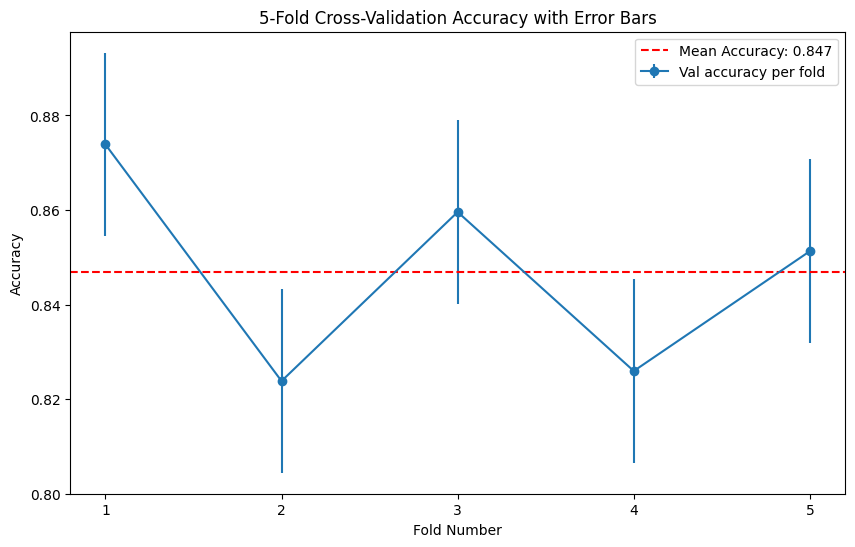

In [16]:
plt.figure(figsize=(10, 6))
plt.errorbar(range(1, n_splits+1), val_acc_folds, yerr=std_acc, fmt='o-', label='Val accuracy per fold')
plt.axhline(mean_acc, color='r', linestyle='--', label=f'Mean Accuracy: {mean_acc:.3f}')
plt.xlabel('Fold Number')
plt.xticks(range(1, n_splits+1))
plt.ylabel('Accuracy')
plt.title('5-Fold Cross-Validation Accuracy with Error Bars')
plt.legend()
plt.show()

### Analyse Different Optimisers with different Settings 

Use the code above to explore different settings for the different optimizers. Use batchsize 64.

1. *SGD*: Refer to the results from above - for later comparison.
<br>

2. *Momentum*: Play with at least three different settings when using momentum: learning rate, momentum parameter, Nesterov flag. Start with momentum=0.9 without Nesterov and suitable learning rate, then vary the momentum parameter and independently the learning rate. Can you see an impact of using Nesterov? What is your recommended best choice (lr, momentum, nesterov, nepochs) for the given problem?
<br>

3. *RMSProp*: Same thing now for RMSprop (without momentum). Play with at least three different settings when using RMSprop: lr, alpha. Start with the default settings of pytorch with (lr=0.01, alpha=0.99,centered=False). Then vary alpha and independently the learning rate. Can you see an impact when using centered=True? What is your recommended best choice (learning rate, alpha, centered, nepochs) for the given problem?<br>
<br>

4. *Adam*: Same thing now for Adam. Play with at least three different settings. Start with the default settings of pytorch. What is your recommended best choice for the given problem?<br>
<br>


In [18]:
sweep_config = {
    'method': 'random',
    'metric': {
        'name': 'val_acc', 
        'goal': 'maximize'
    },
    'parameters': {
        'optimizer': {
            'values': ['SGD', 'RMSprop', 'Adam']
        },
        'lr': {
            'values': [0.001, 0.01, 0.1]
        },
        'momentum': {
            'values': [0.0, 0.9, 0.99],
            # Used for SGD
        },
        'nesterov': {
            'values': [True, False], 
            # Used for SGD
        },
        'alpha': {
            'values': [0.9, 0.99],
            # Used for RMSProp
        },
        'centered': {
            'values': [True, False], 
            # Used for RMSProp
        },
        'betas': {
            'values': [(0.9, 0.999), (0.95, 0.999)],
            # Used for Adam
        },
        'n_epochs': {
            'value': 5
        },
        'batch_size': {
            'value': 64
        }
    }
}

In [19]:
def sweep():
    run = wandb.init(job_type=f'sweep_CNN')
    config = run.config

    train_loader = DataLoader(training_data, batch_size=config.batch_size, shuffle=True)
    val_loader = DataLoader(validation_data, config.batch_size, shuffle=False)

    model = cnn_model().to(device)
    if config.optimizer == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=config.lr, momentum=config.momentum, nesterov=config.nesterov)
    elif config.optimizer == 'RMSprop':
        optimizer = torch.optim.RMSprop(model.parameters(), lr=config.lr, alpha=config.alpha, centered=config.centered)
    elif config.optimizer == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=config.lr, betas=config.betas)

    _ = train_eval(model, optimizer, config.n_epochs, train_loader, val_loader, run)
    
    run.finish()

In [20]:
### YOUR CODE HERE ###
sweep_id = wandb.sweep(sweep_config, entity='jaron-matzinger', project='delearn-pw05')
wandb.agent(sweep_id, function=sweep, count=15)

Create sweep with ID: hzyhzxeu
Sweep URL: https://wandb.ai/jaron-matzinger/delearn-pw05/sweeps/hzyhzxeu


wandb: Agent Starting Run: arou3t38 with config:
wandb: 	alpha: 0.99
wandb: 	batch_size: 64
wandb: 	betas: [0.9, 0.999]
wandb: 	centered: False
wandb: 	lr: 0.001
wandb: 	momentum: 0
wandb: 	n_epochs: 5
wandb: 	nesterov: False
wandb: 	optimizer: Adam


Epoch: 1, Train Loss: 0.5206, Val Loss: 0.3789, Train Acc: 0.8127, Val Acc: 0.8636
Epoch: 2, Train Loss: 0.3404, Val Loss: 0.2986, Train Acc: 0.8765, Val Acc: 0.8873
Epoch: 3, Train Loss: 0.2895, Val Loss: 0.2861, Train Acc: 0.8943, Val Acc: 0.8972
Epoch: 4, Train Loss: 0.2588, Val Loss: 0.2552, Train Acc: 0.9057, Val Acc: 0.9031
Epoch: 5, Train Loss: 0.2353, Val Loss: 0.2490, Train Acc: 0.9134, Val Acc: 0.9081


epoch,▁▃▅▆█
train_acc,▁▅▇▇█
train_loss,█▄▂▂▁
val_acc,▁▅▆▇█
val_loss,█▄▃▁▁
epoch,5
train_acc,0.91342
train_loss,0.23532
val_acc,0.9081
val_loss,0.24897


wandb: Agent Starting Run: hoe98oz8 with config:
wandb: 	alpha: 0.9
wandb: 	batch_size: 64
wandb: 	betas: [0.95, 0.999]
wandb: 	centered: True
wandb: 	lr: 0.01
wandb: 	momentum: 0.99
wandb: 	n_epochs: 5
wandb: 	nesterov: False
wandb: 	optimizer: Adam


Epoch: 1, Train Loss: 0.4455, Val Loss: 0.3319, Train Acc: 0.8366, Val Acc: 0.8802
Epoch: 2, Train Loss: 0.3136, Val Loss: 0.2906, Train Acc: 0.8847, Val Acc: 0.8910
Epoch: 3, Train Loss: 0.2771, Val Loss: 0.2937, Train Acc: 0.8970, Val Acc: 0.8939
Epoch: 4, Train Loss: 0.2571, Val Loss: 0.3252, Train Acc: 0.9040, Val Acc: 0.8861
Epoch: 5, Train Loss: 0.2483, Val Loss: 0.2886, Train Acc: 0.9080, Val Acc: 0.8975


epoch,▁▃▅▆█
train_acc,▁▆▇██
train_loss,█▃▂▁▁
val_acc,▁▅▇▃█
val_loss,█▁▂▇▁
epoch,5
train_acc,0.908
train_loss,0.24832
val_acc,0.8975
val_loss,0.28855


wandb: Agent Starting Run: s68yagdr with config:
wandb: 	alpha: 0.99
wandb: 	batch_size: 64
wandb: 	betas: [0.95, 0.999]
wandb: 	centered: False
wandb: 	lr: 0.01
wandb: 	momentum: 0.9
wandb: 	n_epochs: 5
wandb: 	nesterov: True
wandb: 	optimizer: RMSprop


Epoch: 1, Train Loss: 1.4042, Val Loss: 0.4835, Train Acc: 0.5068, Val Acc: 0.8255
Epoch: 2, Train Loss: 0.4561, Val Loss: 0.4379, Train Acc: 0.8327, Val Acc: 0.8385
Epoch: 3, Train Loss: 0.3737, Val Loss: 0.3488, Train Acc: 0.8617, Val Acc: 0.8685
Epoch: 4, Train Loss: 0.3341, Val Loss: 0.3553, Train Acc: 0.8752, Val Acc: 0.8660
Epoch: 5, Train Loss: 0.3174, Val Loss: 0.3409, Train Acc: 0.8823, Val Acc: 0.8799


epoch,▁▃▅▆█
train_acc,▁▇███
train_loss,█▂▁▁▁
val_acc,▁▃▇▆█
val_loss,█▆▁▂▁
epoch,5
train_acc,0.88232
train_loss,0.31739
val_acc,0.8799
val_loss,0.34093


wandb: Agent Starting Run: 0yl3qgiz with config:
wandb: 	alpha: 0.9
wandb: 	batch_size: 64
wandb: 	betas: [0.95, 0.999]
wandb: 	centered: True
wandb: 	lr: 0.001
wandb: 	momentum: 0.99
wandb: 	n_epochs: 5
wandb: 	nesterov: False
wandb: 	optimizer: SGD


Epoch: 1, Train Loss: 0.9505, Val Loss: 0.4719, Train Acc: 0.6634, Val Acc: 0.8241
Epoch: 2, Train Loss: 0.4114, Val Loss: 0.3738, Train Acc: 0.8520, Val Acc: 0.8614
Epoch: 3, Train Loss: 0.3341, Val Loss: 0.3113, Train Acc: 0.8794, Val Acc: 0.8852
Epoch: 4, Train Loss: 0.3013, Val Loss: 0.2760, Train Acc: 0.8920, Val Acc: 0.8987
Epoch: 5, Train Loss: 0.2744, Val Loss: 0.2712, Train Acc: 0.9003, Val Acc: 0.9058


epoch,▁▃▅▆█
train_acc,▁▇▇██
train_loss,█▂▂▁▁
val_acc,▁▄▆▇█
val_loss,█▅▂▁▁
epoch,5
train_acc,0.90034
train_loss,0.27439
val_acc,0.9058
val_loss,0.27124


wandb: Agent Starting Run: l1w62s6g with config:
wandb: 	alpha: 0.9
wandb: 	batch_size: 64
wandb: 	betas: [0.95, 0.999]
wandb: 	centered: True
wandb: 	lr: 0.001
wandb: 	momentum: 0.99
wandb: 	n_epochs: 5
wandb: 	nesterov: False
wandb: 	optimizer: RMSprop


Epoch: 1, Train Loss: 0.5153, Val Loss: 0.3876, Train Acc: 0.8086, Val Acc: 0.8594
Epoch: 2, Train Loss: 0.3185, Val Loss: 0.3644, Train Acc: 0.8832, Val Acc: 0.8623
Epoch: 3, Train Loss: 0.2680, Val Loss: 0.2736, Train Acc: 0.9012, Val Acc: 0.8972
Epoch: 4, Train Loss: 0.2365, Val Loss: 0.2725, Train Acc: 0.9131, Val Acc: 0.8991
Epoch: 5, Train Loss: 0.2135, Val Loss: 0.2467, Train Acc: 0.9224, Val Acc: 0.9115


epoch,▁▃▅▆█
train_acc,▁▆▇▇█
train_loss,█▃▂▂▁
val_acc,▁▁▆▆█
val_loss,█▇▂▂▁
epoch,5
train_acc,0.92236
train_loss,0.21355
val_acc,0.9115
val_loss,0.24672


wandb: Agent Starting Run: yd6qfhqo with config:
wandb: 	alpha: 0.9
wandb: 	batch_size: 64
wandb: 	betas: [0.9, 0.999]
wandb: 	centered: True
wandb: 	lr: 0.1
wandb: 	momentum: 0.99
wandb: 	n_epochs: 5
wandb: 	nesterov: True
wandb: 	optimizer: Adam


Epoch: 1, Train Loss: 2.6219, Val Loss: 2.3091, Train Acc: 0.1021, Val Acc: 0.0979
Epoch: 2, Train Loss: 2.3109, Val Loss: 2.3132, Train Acc: 0.0985, Val Acc: 0.0982
Epoch: 3, Train Loss: 2.3104, Val Loss: 2.3237, Train Acc: 0.0999, Val Acc: 0.0979
Epoch: 4, Train Loss: 2.3118, Val Loss: 2.3108, Train Acc: 0.0979, Val Acc: 0.1016
Epoch: 5, Train Loss: 2.3111, Val Loss: 2.3184, Train Acc: 0.1016, Val Acc: 0.1000


epoch,▁▃▅▆█
train_acc,█▂▄▁▇
train_loss,█▁▁▁▁
val_acc,▁▂▁█▅
val_loss,▁▃█▂▅
epoch,5
train_acc,0.10158
train_loss,2.31111
val_acc,0.1
val_loss,2.3184


wandb: Agent Starting Run: apob0zzz with config:
wandb: 	alpha: 0.99
wandb: 	batch_size: 64
wandb: 	betas: [0.9, 0.999]
wandb: 	centered: True
wandb: 	lr: 0.01
wandb: 	momentum: 0.9
wandb: 	n_epochs: 5
wandb: 	nesterov: False
wandb: 	optimizer: Adam


Epoch: 1, Train Loss: 0.4698, Val Loss: 0.3268, Train Acc: 0.8291, Val Acc: 0.8791
Epoch: 2, Train Loss: 0.3327, Val Loss: 0.3507, Train Acc: 0.8775, Val Acc: 0.8784
Epoch: 3, Train Loss: 0.3079, Val Loss: 0.3358, Train Acc: 0.8861, Val Acc: 0.8803
Epoch: 4, Train Loss: 0.2925, Val Loss: 0.3189, Train Acc: 0.8903, Val Acc: 0.8800
Epoch: 5, Train Loss: 0.2815, Val Loss: 0.3334, Train Acc: 0.8933, Val Acc: 0.8857


epoch,▁▃▅▆█
train_acc,▁▆▇██
train_loss,█▃▂▁▁
val_acc,▂▁▃▃█
val_loss,▃█▅▁▄
epoch,5
train_acc,0.89328
train_loss,0.28148
val_acc,0.8857
val_loss,0.33344


wandb: Agent Starting Run: 6pu9cw8h with config:
wandb: 	alpha: 0.9
wandb: 	batch_size: 64
wandb: 	betas: [0.9, 0.999]
wandb: 	centered: True
wandb: 	lr: 0.1
wandb: 	momentum: 0.9
wandb: 	n_epochs: 5
wandb: 	nesterov: False
wandb: 	optimizer: RMSprop


Epoch: 1, Train Loss: 48.8759, Val Loss: 2.3255, Train Acc: 0.1268, Val Acc: 0.0992
Epoch: 2, Train Loss: 2.7485, Val Loss: 2.3129, Train Acc: 0.0983, Val Acc: 0.0992
Epoch: 3, Train Loss: 2.3125, Val Loss: 2.3145, Train Acc: 0.0994, Val Acc: 0.0982
Epoch: 4, Train Loss: 2.3131, Val Loss: 2.3351, Train Acc: 0.0980, Val Acc: 0.0989
Epoch: 5, Train Loss: 2.3127, Val Loss: 2.3195, Train Acc: 0.0999, Val Acc: 0.1000


epoch,▁▃▅▆█
train_acc,█▁▁▁▁
train_loss,█▁▁▁▁
val_acc,▅▅▁▄█
val_loss,▅▁▂█▃
epoch,5
train_acc,0.09992
train_loss,2.3127
val_acc,0.1
val_loss,2.31947


wandb: Agent Starting Run: 79spnrjf with config:
wandb: 	alpha: 0.99
wandb: 	batch_size: 64
wandb: 	betas: [0.95, 0.999]
wandb: 	centered: True
wandb: 	lr: 0.001
wandb: 	momentum: 0.9
wandb: 	n_epochs: 5
wandb: 	nesterov: True
wandb: 	optimizer: Adam


Epoch: 1, Train Loss: 0.5535, Val Loss: 0.3766, Train Acc: 0.7983, Val Acc: 0.8654
Epoch: 2, Train Loss: 0.3421, Val Loss: 0.3170, Train Acc: 0.8767, Val Acc: 0.8856
Epoch: 3, Train Loss: 0.2931, Val Loss: 0.2764, Train Acc: 0.8933, Val Acc: 0.9001
Epoch: 4, Train Loss: 0.2621, Val Loss: 0.2702, Train Acc: 0.9030, Val Acc: 0.8948
Epoch: 5, Train Loss: 0.2383, Val Loss: 0.2478, Train Acc: 0.9116, Val Acc: 0.9079


epoch,▁▃▅▆█
train_acc,▁▆▇▇█
train_loss,█▃▂▂▁
val_acc,▁▄▇▆█
val_loss,█▅▃▂▁
epoch,5
train_acc,0.9116
train_loss,0.23829
val_acc,0.9079
val_loss,0.24775


wandb: Agent Starting Run: 6xw3p3fh with config:
wandb: 	alpha: 0.99
wandb: 	batch_size: 64
wandb: 	betas: [0.9, 0.999]
wandb: 	centered: True
wandb: 	lr: 0.01
wandb: 	momentum: 0
wandb: 	n_epochs: 5
wandb: 	nesterov: True
wandb: 	optimizer: Adam


Epoch: 1, Train Loss: 0.4941, Val Loss: 0.3353, Train Acc: 0.8160, Val Acc: 0.8764
Epoch: 2, Train Loss: 0.3305, Val Loss: 0.3216, Train Acc: 0.8784, Val Acc: 0.8797
Epoch: 3, Train Loss: 0.3032, Val Loss: 0.3052, Train Acc: 0.8880, Val Acc: 0.8824
Epoch: 4, Train Loss: 0.2872, Val Loss: 0.2829, Train Acc: 0.8948, Val Acc: 0.8952
Epoch: 5, Train Loss: 0.2769, Val Loss: 0.2885, Train Acc: 0.8972, Val Acc: 0.8989


epoch,▁▃▅▆█
train_acc,▁▆▇██
train_loss,█▃▂▁▁
val_acc,▁▂▃▇█
val_loss,█▆▄▁▂
epoch,5
train_acc,0.89722
train_loss,0.2769
val_acc,0.8989
val_loss,0.28846


wandb: Agent Starting Run: g2v5ixai with config:
wandb: 	alpha: 0.9
wandb: 	batch_size: 64
wandb: 	betas: [0.9, 0.999]
wandb: 	centered: True
wandb: 	lr: 0.001
wandb: 	momentum: 0
wandb: 	n_epochs: 5
wandb: 	nesterov: False
wandb: 	optimizer: RMSprop


Epoch: 1, Train Loss: 0.4887, Val Loss: 0.4318, Train Acc: 0.8223, Val Acc: 0.8440
Epoch: 2, Train Loss: 0.3048, Val Loss: 0.2906, Train Acc: 0.8895, Val Acc: 0.8916
Epoch: 3, Train Loss: 0.2560, Val Loss: 0.2462, Train Acc: 0.9058, Val Acc: 0.9080
Epoch: 4, Train Loss: 0.2268, Val Loss: 0.2417, Train Acc: 0.9158, Val Acc: 0.9152
Epoch: 5, Train Loss: 0.2011, Val Loss: 0.2336, Train Acc: 0.9265, Val Acc: 0.9160


epoch,▁▃▅▆█
train_acc,▁▆▇▇█
train_loss,█▄▂▂▁
val_acc,▁▆▇██
val_loss,█▃▁▁▁
epoch,5
train_acc,0.9265
train_loss,0.20113
val_acc,0.916
val_loss,0.23355


wandb: Agent Starting Run: pa5qxls2 with config:
wandb: 	alpha: 0.9
wandb: 	batch_size: 64
wandb: 	betas: [0.9, 0.999]
wandb: 	centered: False
wandb: 	lr: 0.001
wandb: 	momentum: 0
wandb: 	n_epochs: 5
wandb: 	nesterov: True
wandb: 	optimizer: SGD


Run pa5qxls2 errored:
Traceback (most recent call last):
  File "/Users/jaron/workspace/mse_delearn/.venv/lib/python3.12/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
    self._function()
  File "/var/folders/b6/tgpndp7n76s9pccqsl6nzlfr0000gn/T/ipykernel_26781/3272405722.py", line 10, in sweep
    optimizer = torch.optim.SGD(model.parameters(), lr=config.lr, momentum=config.momentum, nesterov=config.nesterov)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/jaron/workspace/mse_delearn/.venv/lib/python3.12/site-packages/torch/optim/sgd.py", line 62, in __init__
    raise ValueError("Nesterov momentum requires a momentum and zero dampening")
ValueError: Nesterov momentum requires a momentum and zero dampening

wandb: ERROR Run pa5qxls2 errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/Users/jaron/workspace/mse_delearn/.venv/lib/python3.12/site-packages/wandb/ag

Epoch: 1, Train Loss: 1763.4727, Val Loss: 2.3525, Train Acc: 0.0993, Val Acc: 0.0979
Epoch: 2, Train Loss: 2.3227, Val Loss: 2.3433, Train Acc: 0.1001, Val Acc: 0.0989
Epoch: 3, Train Loss: 2.3155, Val Loss: 2.3330, Train Acc: 0.1008, Val Acc: 0.0983
Epoch: 4, Train Loss: 2.3128, Val Loss: 2.3126, Train Acc: 0.1008, Val Acc: 0.1018
Epoch: 5, Train Loss: 2.3131, Val Loss: 2.3134, Train Acc: 0.0998, Val Acc: 0.1000


epoch,▁▃▅▆█
train_acc,▁▅██▃
train_loss,█▁▁▁▁
val_acc,▁▃▂█▅
val_loss,█▆▅▁▁
epoch,5
train_acc,0.09982
train_loss,2.31309
val_acc,0.1
val_loss,2.31338


wandb: Agent Starting Run: pczo404x with config:
wandb: 	alpha: 0.9
wandb: 	batch_size: 64
wandb: 	betas: [0.9, 0.999]
wandb: 	centered: False
wandb: 	lr: 0.001
wandb: 	momentum: 0.99
wandb: 	n_epochs: 5
wandb: 	nesterov: True
wandb: 	optimizer: SGD


Epoch: 1, Train Loss: 0.8706, Val Loss: 0.4321, Train Acc: 0.7015, Val Acc: 0.8495
Epoch: 2, Train Loss: 0.3956, Val Loss: 0.3488, Train Acc: 0.8591, Val Acc: 0.8731
Epoch: 3, Train Loss: 0.3295, Val Loss: 0.3062, Train Acc: 0.8821, Val Acc: 0.8861
Epoch: 4, Train Loss: 0.2955, Val Loss: 0.3022, Train Acc: 0.8934, Val Acc: 0.8900
Epoch: 5, Train Loss: 0.2715, Val Loss: 0.2660, Train Acc: 0.9013, Val Acc: 0.9028


epoch,▁▃▅▆█
train_acc,▁▇▇██
train_loss,█▂▂▁▁
val_acc,▁▄▆▆█
val_loss,█▄▃▃▁
epoch,5
train_acc,0.90126
train_loss,0.27155
val_acc,0.9028
val_loss,0.26602


wandb: Agent Starting Run: u3epir7d with config:
wandb: 	alpha: 0.99
wandb: 	batch_size: 64
wandb: 	betas: [0.9, 0.999]
wandb: 	centered: True
wandb: 	lr: 0.1
wandb: 	momentum: 0
wandb: 	n_epochs: 5
wandb: 	nesterov: False
wandb: 	optimizer: Adam


Epoch: 1, Train Loss: 2.7548, Val Loss: 2.3109, Train Acc: 0.0984, Val Acc: 0.0982
Epoch: 2, Train Loss: 2.3120, Val Loss: 2.3105, Train Acc: 0.0998, Val Acc: 0.0983
Epoch: 3, Train Loss: 2.3119, Val Loss: 2.3068, Train Acc: 0.0989, Val Acc: 0.1018
Epoch: 4, Train Loss: 2.3113, Val Loss: 2.3070, Train Acc: 0.1004, Val Acc: 0.1018
Epoch: 5, Train Loss: 2.3118, Val Loss: 2.3085, Train Acc: 0.1001, Val Acc: 0.0989


epoch,▁▃▅▆█
train_acc,▁▆▃█▇
train_loss,█▁▁▁▁
val_acc,▁▁██▂
val_loss,█▇▁▁▄
epoch,5
train_acc,0.10014
train_loss,2.31184
val_acc,0.0989
val_loss,2.30849


### Plots and Comments (for the different steps described above) 

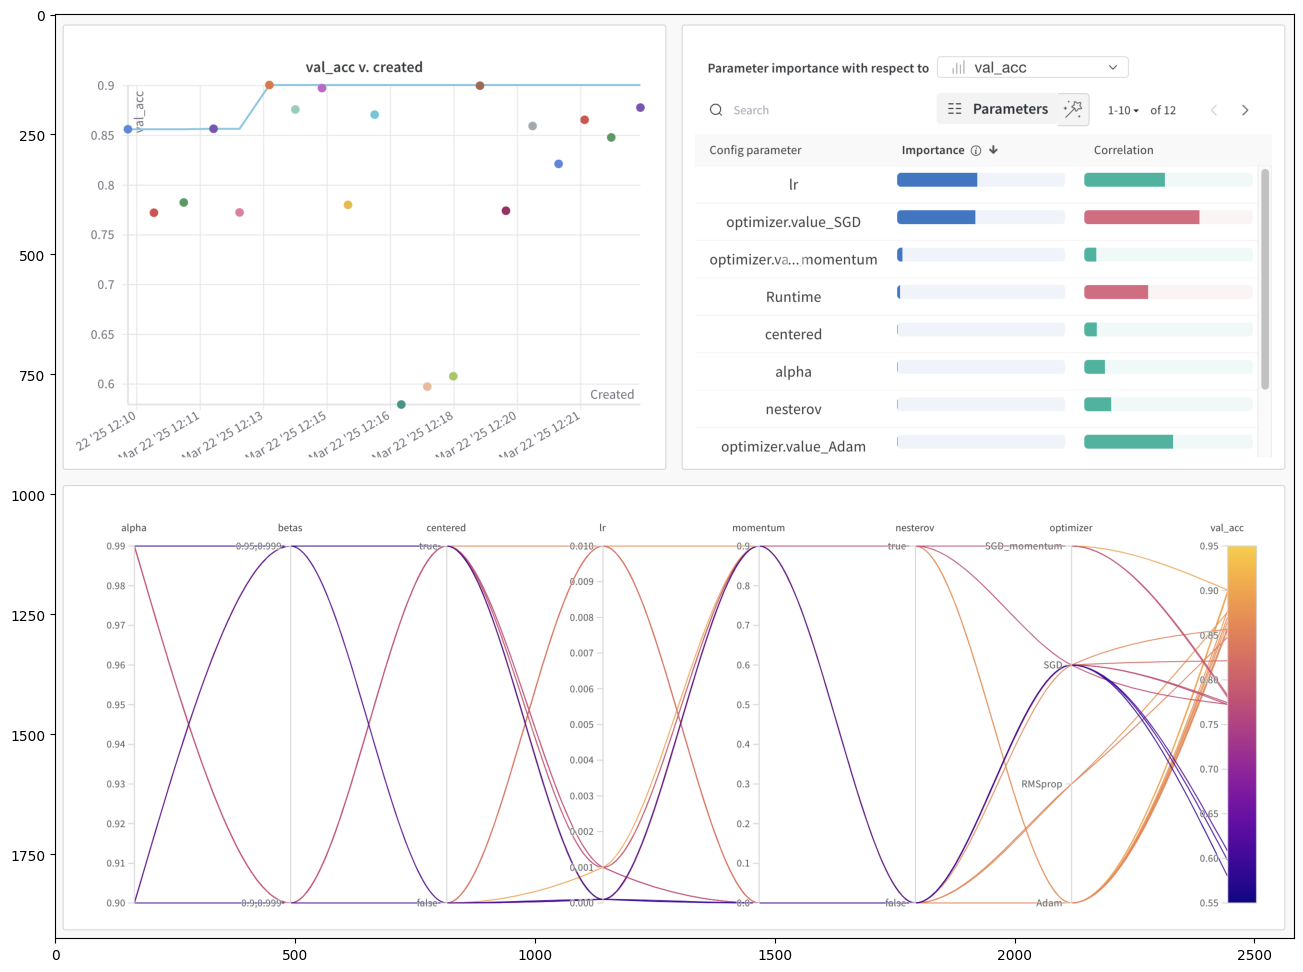

In [21]:
from PIL import Image

img = np.array(Image.open('wandb_sweep.png'))
fig = plt.figure(figsize=(24,12))
plt.imshow(img)

### Learning Rate Schedule

Modify your `train_eval` method implemented above to support using a learning rate schedule for SGD (without momentum) - by using e.g. StepLR. What are your preferred settings for the given task?

Compare and evaluate the training performance with the results obtained for the different optimizers above and provide a judgement.

In [22]:
sweep_config = {
    'method': 'random',
    'metric': {
        'name': 'val_acc', 
        'goal': 'maximize'
    },
    'parameters': {
        'optimizer': {
            'value': 'SGD',
        },
        'lr': {
            'value': 0.001
        },
        'step_size': {
            'values': [1, 2, 3],
        },
        'gamma': {
            'values': [0.1, 0.2, 0.3],
        },
        'n_epochs': {
            'value': 5
        },
        'batch_size': {
            'value': 64
        }
    }
}

In [ ]:
def sweep():
    run = wandb.init(job_type=f'sweep_CNN')
    config = run.config

    train_loader = DataLoader(training_data, batch_size=config.batch_size, shuffle=True)
    val_loader = DataLoader(validation_data, config.batch_size, shuffle=False)

    model = cnn_model().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=config.lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=config.step_size, gamma=config.gamma)

    _ = train_eval(model, optimizer, config.n_epochs, train_loader, val_loader, run, scheduler=scheduler)
    
    run.finish()

In [24]:
sweep_id = wandb.sweep(sweep_config, entity='jaron-matzinger', project='delearn-pw05')
wandb.agent(sweep_id, function=sweep, count=15)

Create sweep with ID: 6h4vy5i4
Sweep URL: https://wandb.ai/jaron-matzinger/delearn-pw05/sweeps/6h4vy5i4


wandb: Agent Starting Run: 4s8nihlf with config:
wandb: 	batch_size: 64
wandb: 	gamma: 0.2
wandb: 	lr: 0.001
wandb: 	n_epochs: 5
wandb: 	optimizer: SGD
wandb: 	step_size: 2


Epoch: 1, Train Loss: 2.2949, Val Loss: 2.2806, Train Acc: 0.2256, Val Acc: 0.2731
Epoch: 2, Train Loss: 2.2499, Val Loss: 2.1984, Train Acc: 0.3720, Val Acc: 0.4780
Epoch: 3, Train Loss: 2.1787, Val Loss: 2.1573, Train Acc: 0.4875, Val Acc: 0.4961
Epoch: 4, Train Loss: 2.1282, Val Loss: 2.0967, Train Acc: 0.5048, Val Acc: 0.5138
Epoch: 5, Train Loss: 2.0884, Val Loss: 2.0816, Train Acc: 0.5180, Val Acc: 0.5189


epoch,▁▃▅▆█
train_acc,▁▅▇██
train_loss,█▆▄▂▁
val_acc,▁▇▇██
val_loss,█▅▄▂▁
epoch,5
train_acc,0.51798
train_loss,2.08843
val_acc,0.5189
val_loss,2.08159


wandb: Agent Starting Run: ii6axasi with config:
wandb: 	batch_size: 64
wandb: 	gamma: 0.1
wandb: 	lr: 0.001
wandb: 	n_epochs: 5
wandb: 	optimizer: SGD
wandb: 	step_size: 2


Epoch: 1, Train Loss: 2.2817, Val Loss: 2.2570, Train Acc: 0.1279, Val Acc: 0.2208
Epoch: 2, Train Loss: 2.1993, Val Loss: 2.0990, Train Acc: 0.2507, Val Acc: 0.3691
Epoch: 3, Train Loss: 2.0801, Val Loss: 2.0620, Train Acc: 0.3868, Val Acc: 0.4145
Epoch: 4, Train Loss: 2.0394, Val Loss: 2.0176, Train Acc: 0.4299, Val Acc: 0.4537
Epoch: 5, Train Loss: 2.0139, Val Loss: 2.0127, Train Acc: 0.4531, Val Acc: 0.4575


epoch,▁▃▅▆█
train_acc,▁▄▇██
train_loss,█▆▃▂▁
val_acc,▁▅▇██
val_loss,█▃▂▁▁
epoch,5
train_acc,0.45306
train_loss,2.01392
val_acc,0.4575
val_loss,2.0127


wandb: Agent Starting Run: qzlylxai with config:
wandb: 	batch_size: 64
wandb: 	gamma: 0.2
wandb: 	lr: 0.001
wandb: 	n_epochs: 5
wandb: 	optimizer: SGD
wandb: 	step_size: 1


Epoch: 1, Train Loss: 2.2714, Val Loss: 2.2242, Train Acc: 0.1292, Val Acc: 0.2137
Epoch: 2, Train Loss: 2.2079, Val Loss: 2.1899, Train Acc: 0.2814, Val Acc: 0.3558
Epoch: 3, Train Loss: 2.1854, Val Loss: 2.1814, Train Acc: 0.3674, Val Acc: 0.3825
Epoch: 4, Train Loss: 2.1802, Val Loss: 2.1796, Train Acc: 0.3824, Val Acc: 0.3883
Epoch: 5, Train Loss: 2.1792, Val Loss: 2.1792, Train Acc: 0.3860, Val Acc: 0.3894


epoch,▁▃▅▆█
train_acc,▁▅▇██
train_loss,█▃▁▁▁
val_acc,▁▇███
val_loss,█▃▁▁▁
epoch,5
train_acc,0.38596
train_loss,2.17916
val_acc,0.3894
val_loss,2.17923


wandb: Agent Starting Run: i25aj3d6 with config:
wandb: 	batch_size: 64
wandb: 	gamma: 0.3
wandb: 	lr: 0.001
wandb: 	n_epochs: 5
wandb: 	optimizer: SGD
wandb: 	step_size: 3


Epoch: 1, Train Loss: 2.2872, Val Loss: 2.2670, Train Acc: 0.1987, Val Acc: 0.2849
Epoch: 2, Train Loss: 2.2235, Val Loss: 2.1518, Train Acc: 0.3203, Val Acc: 0.3625
Epoch: 3, Train Loss: 1.9321, Val Loss: 1.5837, Train Acc: 0.4773, Val Acc: 0.5842
Epoch: 4, Train Loss: 1.4570, Val Loss: 1.3351, Train Acc: 0.6087, Val Acc: 0.6238
Epoch: 5, Train Loss: 1.2434, Val Loss: 1.1563, Train Acc: 0.6262, Val Acc: 0.6341


epoch,▁▃▅▆█
train_acc,▁▃▆██
train_loss,██▆▂▁
val_acc,▁▃▇██
val_loss,█▇▄▂▁
epoch,5
train_acc,0.62616
train_loss,1.2434
val_acc,0.6341
val_loss,1.15634


wandb: Agent Starting Run: c1exbkrp with config:
wandb: 	batch_size: 64
wandb: 	gamma: 0.1
wandb: 	lr: 0.001
wandb: 	n_epochs: 5
wandb: 	optimizer: SGD
wandb: 	step_size: 3


Epoch: 1, Train Loss: 2.2661, Val Loss: 2.2122, Train Acc: 0.2277, Val Acc: 0.4033
Epoch: 2, Train Loss: 2.0398, Val Loss: 1.7336, Train Acc: 0.4860, Val Acc: 0.5868
Epoch: 3, Train Loss: 1.3219, Val Loss: 1.0288, Train Acc: 0.6145, Val Acc: 0.6574
Epoch: 4, Train Loss: 1.0194, Val Loss: 0.9972, Train Acc: 0.6565, Val Acc: 0.6573
Epoch: 5, Train Loss: 0.9910, Val Loss: 0.9704, Train Acc: 0.6610, Val Acc: 0.6674


epoch,▁▃▅▆█
train_acc,▁▅▇██
train_loss,█▇▃▁▁
val_acc,▁▆███
val_loss,█▅▁▁▁
epoch,5
train_acc,0.66096
train_loss,0.99104
val_acc,0.6674
val_loss,0.97042


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qyqolakg with config:
wandb: 	batch_size: 64
wandb: 	gamma: 0.3
wandb: 	lr: 0.001
wandb: 	n_epochs: 5
wandb: 	optimizer: SGD
wandb: 	step_size: 1


Epoch: 1, Train Loss: 2.2677, Val Loss: 2.2182, Train Acc: 0.2011, Val Acc: 0.2449
Epoch: 2, Train Loss: 2.1898, Val Loss: 2.1576, Train Acc: 0.2490, Val Acc: 0.2621
Epoch: 3, Train Loss: 2.1442, Val Loss: 2.1321, Train Acc: 0.2646, Val Acc: 0.2718
Epoch: 4, Train Loss: 2.1268, Val Loss: 2.1236, Train Acc: 0.2704, Val Acc: 0.2758
Epoch: 5, Train Loss: 2.1213, Val Loss: 2.1210, Train Acc: 0.2722, Val Acc: 0.2769


epoch,▁▃▅▆█
train_acc,▁▆▇██
train_loss,█▄▂▁▁
val_acc,▁▅▇██
val_loss,█▄▂▁▁
epoch,5
train_acc,0.2722
train_loss,2.12127
val_acc,0.2769
val_loss,2.121


wandb: Agent Starting Run: 9t6gk70l with config:
wandb: 	batch_size: 64
wandb: 	gamma: 0.2
wandb: 	lr: 0.001
wandb: 	n_epochs: 5
wandb: 	optimizer: SGD
wandb: 	step_size: 3


Epoch: 1, Train Loss: 2.2451, Val Loss: 2.1575, Train Acc: 0.1382, Val Acc: 0.2656
Epoch: 2, Train Loss: 1.8679, Val Loss: 1.4423, Train Acc: 0.4637, Val Acc: 0.5809
Epoch: 3, Train Loss: 1.1496, Val Loss: 0.9615, Train Acc: 0.6207, Val Acc: 0.6589
Epoch: 4, Train Loss: 0.9461, Val Loss: 0.9206, Train Acc: 0.6641, Val Acc: 0.6686
Epoch: 5, Train Loss: 0.9108, Val Loss: 0.8886, Train Acc: 0.6735, Val Acc: 0.6810


epoch,▁▃▅▆█
train_acc,▁▅▇██
train_loss,█▆▂▁▁
val_acc,▁▆███
val_loss,█▄▁▁▁
epoch,5
train_acc,0.67354
train_loss,0.91076
val_acc,0.681
val_loss,0.8886


wandb: Agent Starting Run: 6abaz4t9 with config:
wandb: 	batch_size: 64
wandb: 	gamma: 0.3
wandb: 	lr: 0.001
wandb: 	n_epochs: 5
wandb: 	optimizer: SGD
wandb: 	step_size: 3


Epoch: 1, Train Loss: 2.2840, Val Loss: 2.2572, Train Acc: 0.1515, Val Acc: 0.2877
Epoch: 2, Train Loss: 2.1828, Val Loss: 2.0495, Train Acc: 0.3538, Val Acc: 0.4525
Epoch: 3, Train Loss: 1.6919, Val Loss: 1.2962, Train Acc: 0.5390, Val Acc: 0.5961
Epoch: 4, Train Loss: 1.2130, Val Loss: 1.1360, Train Acc: 0.6049, Val Acc: 0.6178
Epoch: 5, Train Loss: 1.0844, Val Loss: 1.0317, Train Acc: 0.6255, Val Acc: 0.6380


epoch,▁▃▅▆█
train_acc,▁▄▇██
train_loss,█▇▅▂▁
val_acc,▁▄▇██
val_loss,█▇▃▂▁
epoch,5
train_acc,0.62546
train_loss,1.0844
val_acc,0.638
val_loss,1.03167


wandb: Agent Starting Run: jkw6f2i3 with config:
wandb: 	batch_size: 64
wandb: 	gamma: 0.3
wandb: 	lr: 0.001
wandb: 	n_epochs: 5
wandb: 	optimizer: SGD
wandb: 	step_size: 2


Epoch: 1, Train Loss: 2.2745, Val Loss: 2.2408, Train Acc: 0.1513, Val Acc: 0.2598
Epoch: 2, Train Loss: 2.1471, Val Loss: 1.9760, Train Acc: 0.4092, Val Acc: 0.5564
Epoch: 3, Train Loss: 1.8713, Val Loss: 1.7500, Train Acc: 0.5834, Val Acc: 0.5874
Epoch: 4, Train Loss: 1.6085, Val Loss: 1.4649, Train Acc: 0.5841, Val Acc: 0.6063
Epoch: 5, Train Loss: 1.4271, Val Loss: 1.3864, Train Acc: 0.6030, Val Acc: 0.6084


epoch,▁▃▅▆█
train_acc,▁▅███
train_loss,█▇▅▂▁
val_acc,▁▇███
val_loss,█▆▄▂▁
epoch,5
train_acc,0.60298
train_loss,1.42711
val_acc,0.6084
val_loss,1.38642


wandb: Agent Starting Run: xlqw7w60 with config:
wandb: 	batch_size: 64
wandb: 	gamma: 0.3
wandb: 	lr: 0.001
wandb: 	n_epochs: 5
wandb: 	optimizer: SGD
wandb: 	step_size: 2


Epoch: 1, Train Loss: 2.2892, Val Loss: 2.2696, Train Acc: 0.1069, Val Acc: 0.1646
Epoch: 2, Train Loss: 2.2230, Val Loss: 2.1444, Train Acc: 0.2575, Val Acc: 0.4090
Epoch: 3, Train Loss: 2.0958, Val Loss: 2.0383, Train Acc: 0.4434, Val Acc: 0.4966
Epoch: 4, Train Loss: 1.9550, Val Loss: 1.8589, Train Acc: 0.5099, Val Acc: 0.5329
Epoch: 5, Train Loss: 1.8244, Val Loss: 1.7898, Train Acc: 0.5326, Val Acc: 0.5396


epoch,▁▃▅▆█
train_acc,▁▃▇██
train_loss,█▇▅▃▁
val_acc,▁▆▇██
val_loss,█▆▅▂▁
epoch,5
train_acc,0.53258
train_loss,1.82441
val_acc,0.5396
val_loss,1.78978


wandb: Agent Starting Run: y1q3q0z8 with config:
wandb: 	batch_size: 64
wandb: 	gamma: 0.2
wandb: 	lr: 0.001
wandb: 	n_epochs: 5
wandb: 	optimizer: SGD
wandb: 	step_size: 2


Epoch: 1, Train Loss: 2.2866, Val Loss: 2.2660, Train Acc: 0.1003, Val Acc: 0.1024
Epoch: 2, Train Loss: 2.2196, Val Loss: 2.1425, Train Acc: 0.2628, Val Acc: 0.3683
Epoch: 3, Train Loss: 2.1138, Val Loss: 2.0824, Train Acc: 0.3832, Val Acc: 0.4102
Epoch: 4, Train Loss: 2.0416, Val Loss: 1.9968, Train Acc: 0.4349, Val Acc: 0.4640
Epoch: 5, Train Loss: 1.9858, Val Loss: 1.9759, Train Acc: 0.4681, Val Acc: 0.4744


epoch,▁▃▅▆█
train_acc,▁▄▆▇█
train_loss,█▆▄▂▁
val_acc,▁▆▇██
val_loss,█▅▄▂▁
epoch,5
train_acc,0.46814
train_loss,1.98583
val_acc,0.4744
val_loss,1.97588


wandb: Agent Starting Run: a5mso2xw with config:
wandb: 	batch_size: 64
wandb: 	gamma: 0.3
wandb: 	lr: 0.001
wandb: 	n_epochs: 5
wandb: 	optimizer: SGD
wandb: 	step_size: 3


Epoch: 1, Train Loss: 2.2615, Val Loss: 2.2013, Train Acc: 0.1936, Val Acc: 0.2906
Epoch: 2, Train Loss: 1.9991, Val Loss: 1.6563, Train Acc: 0.4091, Val Acc: 0.6001
Epoch: 3, Train Loss: 1.2826, Val Loss: 1.0353, Train Acc: 0.6104, Val Acc: 0.6291
Epoch: 4, Train Loss: 0.9975, Val Loss: 0.9566, Train Acc: 0.6423, Val Acc: 0.6574
Epoch: 5, Train Loss: 0.9379, Val Loss: 0.9057, Train Acc: 0.6586, Val Acc: 0.6661


epoch,▁▃▅▆█
train_acc,▁▄▇██
train_loss,█▇▃▁▁
val_acc,▁▇▇██
val_loss,█▅▂▁▁
epoch,5
train_acc,0.6586
train_loss,0.93786
val_acc,0.6661
val_loss,0.90569


wandb: Agent Starting Run: a7h8pf7a with config:
wandb: 	batch_size: 64
wandb: 	gamma: 0.1
wandb: 	lr: 0.001
wandb: 	n_epochs: 5
wandb: 	optimizer: SGD
wandb: 	step_size: 1


Epoch: 1, Train Loss: 2.2653, Val Loss: 2.2093, Train Acc: 0.2175, Val Acc: 0.3690
Epoch: 2, Train Loss: 2.1992, Val Loss: 2.1898, Train Acc: 0.3788, Val Acc: 0.3844
Epoch: 3, Train Loss: 2.1881, Val Loss: 2.1877, Train Acc: 0.3877, Val Acc: 0.3853
Epoch: 4, Train Loss: 2.1869, Val Loss: 2.1875, Train Acc: 0.3881, Val Acc: 0.3858
Epoch: 5, Train Loss: 2.1868, Val Loss: 2.1875, Train Acc: 0.3882, Val Acc: 0.3858


epoch,▁▃▅▆█
train_acc,▁████
train_loss,█▂▁▁▁
val_acc,▁▇███
val_loss,█▂▁▁▁
epoch,5
train_acc,0.38818
train_loss,2.18676
val_acc,0.3858
val_loss,2.18746


wandb: Agent Starting Run: gr32ojnb with config:
wandb: 	batch_size: 64
wandb: 	gamma: 0.2
wandb: 	lr: 0.001
wandb: 	n_epochs: 5
wandb: 	optimizer: SGD
wandb: 	step_size: 1


Epoch: 1, Train Loss: 2.2880, Val Loss: 2.2697, Train Acc: 0.1405, Val Acc: 0.2624
Epoch: 2, Train Loss: 2.2641, Val Loss: 2.2588, Train Acc: 0.3185, Val Acc: 0.3427
Epoch: 3, Train Loss: 2.2572, Val Loss: 2.2563, Train Acc: 0.3498, Val Acc: 0.3517
Epoch: 4, Train Loss: 2.2556, Val Loss: 2.2557, Train Acc: 0.3551, Val Acc: 0.3538
Epoch: 5, Train Loss: 2.2553, Val Loss: 2.2556, Train Acc: 0.3565, Val Acc: 0.3539


epoch,▁▃▅▆█
train_acc,▁▇███
train_loss,█▃▁▁▁
val_acc,▁▇███
val_loss,█▃▁▁▁
epoch,5
train_acc,0.35652
train_loss,2.25531
val_acc,0.3539
val_loss,2.25563


wandb: Agent Starting Run: exvxy4ap with config:
wandb: 	batch_size: 64
wandb: 	gamma: 0.3
wandb: 	lr: 0.001
wandb: 	n_epochs: 5
wandb: 	optimizer: SGD
wandb: 	step_size: 1


Epoch: 1, Train Loss: 2.2890, Val Loss: 2.2698, Train Acc: 0.1367, Val Acc: 0.1831
Epoch: 2, Train Loss: 2.2617, Val Loss: 2.2530, Train Acc: 0.2235, Val Acc: 0.2438
Epoch: 3, Train Loss: 2.2496, Val Loss: 2.2467, Train Acc: 0.2526, Val Acc: 0.2624
Epoch: 4, Train Loss: 2.2453, Val Loss: 2.2446, Train Acc: 0.2643, Val Acc: 0.2678
Epoch: 5, Train Loss: 2.2440, Val Loss: 2.2440, Train Acc: 0.2686, Val Acc: 0.2703


epoch,▁▃▅▆█
train_acc,▁▆▇██
train_loss,█▄▂▁▁
val_acc,▁▆▇██
val_loss,█▃▂▁▁
epoch,5
train_acc,0.26856
train_loss,2.24396
val_acc,0.2703
val_loss,2.24396


wandb: Agent Starting Run: teiysf1a with config:
wandb: 	batch_size: 64
wandb: 	gamma: 0.1
wandb: 	lr: 0.001
wandb: 	n_epochs: 5
wandb: 	optimizer: SGD
wandb: 	step_size: 2


Epoch: 1, Train Loss: 2.2897, Val Loss: 2.2753, Train Acc: 0.1258, Val Acc: 0.1954
Epoch: 2, Train Loss: 2.2451, Val Loss: 2.1982, Train Acc: 0.2909, Val Acc: 0.3404
Epoch: 3, Train Loss: 2.1898, Val Loss: 2.1820, Train Acc: 0.3627, Val Acc: 0.3803
Epoch: 4, Train Loss: 2.1721, Val Loss: 2.1628, Train Acc: 0.4014, Val Acc: 0.4143
Epoch: 5, Train Loss: 2.1612, Val Loss: 2.1607, Train Acc: 0.4179, Val Acc: 0.4162


epoch,▁▃▅▆█
train_acc,▁▅▇██
train_loss,█▆▃▂▁
val_acc,▁▆▇██
val_loss,█▃▂▁▁
epoch,5
train_acc,0.41794
train_loss,2.16118
val_acc,0.4162
val_loss,2.16073


wandb: Agent Starting Run: zk9sny2g with config:
wandb: 	batch_size: 64
wandb: 	gamma: 0.2
wandb: 	lr: 0.001
wandb: 	n_epochs: 5
wandb: 	optimizer: SGD
wandb: 	step_size: 3


Epoch: 1, Train Loss: 2.2837, Val Loss: 2.2569, Train Acc: 0.1786, Val Acc: 0.2293
Epoch: 2, Train Loss: 2.1898, Val Loss: 2.0739, Train Acc: 0.3533, Val Acc: 0.4211
Epoch: 3, Train Loss: 1.7519, Val Loss: 1.3597, Train Acc: 0.5130, Val Acc: 0.5980
Epoch: 4, Train Loss: 1.2957, Val Loss: 1.2321, Train Acc: 0.6131, Val Acc: 0.6118
Epoch: 5, Train Loss: 1.1836, Val Loss: 1.1324, Train Acc: 0.6250, Val Acc: 0.6320


epoch,▁▃▅▆█
train_acc,▁▄▆██
train_loss,█▇▅▂▁
val_acc,▁▄▇██
val_loss,█▇▂▂▁
epoch,5
train_acc,0.625
train_loss,1.18359
val_acc,0.632
val_loss,1.13245


wandb: Agent Starting Run: iize276h with config:
wandb: 	batch_size: 64
wandb: 	gamma: 0.3
wandb: 	lr: 0.001
wandb: 	n_epochs: 5
wandb: 	optimizer: SGD
wandb: 	step_size: 1


Epoch: 1, Train Loss: 2.2808, Val Loss: 2.2499, Train Acc: 0.2352, Val Acc: 0.2638
Epoch: 2, Train Loss: 2.2337, Val Loss: 2.2145, Train Acc: 0.2724, Val Acc: 0.2806
Epoch: 3, Train Loss: 2.2073, Val Loss: 2.1997, Train Acc: 0.2969, Val Acc: 0.2968
Epoch: 4, Train Loss: 2.1971, Val Loss: 2.1948, Train Acc: 0.3059, Val Acc: 0.3040
Epoch: 5, Train Loss: 2.1939, Val Loss: 2.1932, Train Acc: 0.3100, Val Acc: 0.3068


epoch,▁▃▅▆█
train_acc,▁▄▇██
train_loss,█▄▂▁▁
val_acc,▁▄▆██
val_loss,█▄▂▁▁
epoch,5
train_acc,0.31
train_loss,2.19387
val_acc,0.3068
val_loss,2.19322


wandb: Agent Starting Run: 8dun40fn with config:
wandb: 	batch_size: 64
wandb: 	gamma: 0.2
wandb: 	lr: 0.001
wandb: 	n_epochs: 5
wandb: 	optimizer: SGD
wandb: 	step_size: 2


Epoch: 1, Train Loss: 2.2916, Val Loss: 2.2763, Train Acc: 0.1648, Val Acc: 0.1870
Epoch: 2, Train Loss: 2.2451, Val Loss: 2.1968, Train Acc: 0.2240, Val Acc: 0.3071
Epoch: 3, Train Loss: 2.1785, Val Loss: 2.1600, Train Acc: 0.3341, Val Acc: 0.3455
Epoch: 4, Train Loss: 2.1341, Val Loss: 2.1072, Train Acc: 0.3779, Val Acc: 0.4132
Epoch: 5, Train Loss: 2.0994, Val Loss: 2.0941, Train Acc: 0.4249, Val Acc: 0.4308


epoch,▁▃▅▆█
train_acc,▁▃▆▇█
train_loss,█▆▄▂▁
val_acc,▁▄▆▇█
val_loss,█▅▄▂▁
epoch,5
train_acc,0.42486
train_loss,2.09937
val_acc,0.4308
val_loss,2.09406


wandb: Agent Starting Run: 2ql4myq8 with config:
wandb: 	batch_size: 64
wandb: 	gamma: 0.3
wandb: 	lr: 0.001
wandb: 	n_epochs: 5
wandb: 	optimizer: SGD
wandb: 	step_size: 1


Epoch: 1, Train Loss: 2.2908, Val Loss: 2.2713, Train Acc: 0.2349, Val Acc: 0.3406
Epoch: 2, Train Loss: 2.2625, Val Loss: 2.2520, Train Acc: 0.3574, Val Acc: 0.3594
Epoch: 3, Train Loss: 2.2482, Val Loss: 2.2443, Train Acc: 0.3649, Val Acc: 0.3683
Epoch: 4, Train Loss: 2.2430, Val Loss: 2.2418, Train Acc: 0.3727, Val Acc: 0.3731
Epoch: 5, Train Loss: 2.2413, Val Loss: 2.2410, Train Acc: 0.3743, Val Acc: 0.3745


epoch,▁▃▅▆█
train_acc,▁▇███
train_loss,█▄▂▁▁
val_acc,▁▅▇██
val_loss,█▄▂▁▁
epoch,5
train_acc,0.37426
train_loss,2.24132
val_acc,0.3745
val_loss,2.24099


According to wandb the best hyperparameters for the task were:
- step_size: 3
- gamma: 0.3